# Unsupervised Learning

This notebook demonstrates how to implement the kmeans clustering algorithm using numpy. The assumptions of the kmeans algorithm are equivalent to assuming that the underlying data generating process is defined by k different gaussian distributions with constant variance but different means i.e., the pdf is assumed to be of the form:
$p(x) = \sum_{i=1}^{k}N(\mu_{i}, \sigma)$ were k defines the number of clusters.

Kmeans is a non-parametric algorithm and uses distances between points within the metric space defined by the input data. 


## Authors
- Joshua Spear, joshua.spear.21@ucl.ac.uk

## Learning Outcomes
- Gain intuition regarding how the kmeans algorithm is implemented, in particular how the cluster assignment stage and cluster centre calculation stage iterate
    - Students should focus on implementing the algorithm using numpy operations to understand how to efficiently handle vector and matrix structures in Python
    - Students should also pay attention to the additional steps required when implementing algorithms on real data. For example, reinitialisation of cluster centres
- Gain intuition regarding how the number of clusters can be chosen using the silhouette score

Extension:
- Gain intuition regarding how different distance metrics can be used to handle different types of data
- Gain intuition regarding how the assumptions of kmeans effects performance of the algorithm

## Task

In order to implement and understand the kmeans algorithm, data will be simulated using the 'make_blobs' function from sklearn. The notebook will then demonstrate how to implement the kmeans algorithm using object-orientated programming in Python.

## Importing Libraries

In [1]:
# Special interface functionality in Python (described later)
from abc import ABCMeta, abstractmethod
from typing import Callable

# Popular library in Python for manipulating vector, matrices and larger tensor objects
import numpy as np

# Required for dataset construction
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import silhouette_score, confusion_matrix
# Plotting library
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# Required for extension
from fastdtw import fastdtw

## Generating the data 

For the initial task, a dataset will be generated by parameterising isotropic (spherical) gaussian distributions with constant standard deviation. This is done by utilising the 'make_blobs' function from sklearn

In [2]:
centres = 5 # Number of Multivariate Gaussian distributions in the underlying data generating process
n_features = 10 # Dimension of each individual gaussian distribution
X, y = make_blobs(
    n_samples=100, # Number of independant samples to generate
    n_features=n_features,
    centers=centres, 
    random_state=42 # Seed of random number generator to ensure results are repeatable 
)

Next, split the data into training and test where 20\% of observations are held out for the test set

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Distance metrics
The kmeans algorithm clusters observations based on their distance to different centres. Therefore, the first step of implementing a kmeans algorithm is to define the distance metric to be used. To begin with, the euclidean distance will be used.

#### OOP programming
Whilst the aim of this tutorial is not to teach OOP programming, a number of different machine learning packages are implemented using 'stateful' OOP implementations therefore, such an implementation will be used here. A class defines a blueprint for creating objects, where objects have data associated with them and generally have methods which 'do things' to that data.

'Metaclasses' and 'abstractmethods' are used to provide an interface for implementing different types of classes which are expected to share some structure that is implemented in the child classes. The DistanceMetric metaclass below will be used to build different distance metrics. The \_\_call\_\_ dunder method allows the class to be called like a function - see the 'HelloWorld' class as an illustration.

The DistanceMetric metaclass is used to:
- Implement generic functionality which checks that the inputs to the distance metric calculation is consistant (__Metaclass reason 1__)
2. Provides a consistent type to use in the KMeans clusterer class later on (__Metaclass reason 2__)

The code has been marked with Metaclass reason 1/Metaclass reason 2 to indicate where the metaclass is useful in the later code.

In [4]:
class HelloWorld:
    
    def __call__(self):
        print("Hello World!")
        
hw = HelloWorld()
hw()

Hello World!


In [5]:
class DistanceMetric(metaclass=ABCMeta):
    
    @abstractmethod
    def distance_calculation(self, x:np.array, y:np.array)->np.array:
        pass
    
    def __call__(self, x:np.array, y:np.array)->np.array: #Metaclass reason 1
        if not (len(x.shape) == len(x.shape) == 1): 
            raise Exception("Both x and y must be a single dimension")
        return self.distance_calculation(x,y)

### Exercise
Add a method to the EuclideanDistance class defined below, to calculate the euclidean distance between two vectors. 

__HINT__: The EuclideanDistance class 'inherits' from the DistanceMetric class i.e., it has all of the functionality defined in the DistanceMetric. Therefore, the only functionality that needs to be added to the EuclideanDistance is the 'distance_calculation' method.

In [6]:
class EuclideanDistance(DistanceMetric):
     def distance_calculation(self, x:np.array, y:np.array)->np.array:
            return np.sqrt(np.sum((x - y) ** 2))
        
    

Once we have defined the EuclideanDistance we need to instantiate a EuclideanDistance object. This object can be used any number of times that is required.

In [7]:
ed = EuclideanDistance()
# X = np.array([2,4])
# Y = np.array([1,3])
# testExample = ed.distance_calculation(X,Y)
# print(testExample)

## Kmeans clustering class
The kmeans clustering algorithm will be implemented as a class with a fit and predict method - similar to the very familiar sklearn API. Implementing the algorithm using the class defined below will make implementing later parts of the machine learning pipeline easier. For example, the KMeansClusterer below is implemented with an _n\_clusters_ attribute. Therefore, p different instantiations of the kmeans algorithm can easily be implemented which will make hyperparamerter tuning significantly easier.

The following few exercises will focus on implementing the get_random_clusters, assign_centres and fit functions that the KMeansClusterer class calls. These functions have been defined externally to the KMeansClusterer class for the puporses of stepping through this notebook - ordinarily they would be implemented directly into the KMeansClusterer class as methods.

Within the KMeansClusterer class, a _predict_ method has already been provided however, note that the method relies on _assign_centres_ which has not yet been implemented.  A _check_input_data_ method has also been provided which is used in the _predict_ and _fit_ methods to provide useful debugging information to the end user and prevent incorrect results.

### Exercise
The kmeans algorithm relies on an initial setting for the clusters centres, therefore the first step is to implement the _get_random_clusters_ method which will be used to initialise the cluster centres. The method should take the argument, X, which is an np.array defining the training data and therefore should be of shape (number of observations, number of features). The method should return a numpy array of shape (number of cluster centres, number of features). Finally, the cluster centres will be initialised by drawing samples from an independant uniform random variable for each feature, parameterised by the observed min and max for each feature. Use the cell below to check your code.

__HINT__: Use the np.random.uniform function to generate an numpy array of shape (number of cluster centres, number of features).

In [8]:
def get_random_clusters(X, n_clusters):
    #X:: [#observations, #features]
    min_X = np.min(X,axis =0)
    max_X = np.max(X, axis =0)
    f = np.random.uniform(low=min_X,high=max_X, size=(n_clusters, X.shape[1]))
    return f
#(number of cluster centres, number of features).
    

In [9]:
n_clusters = centres
cluster_init = get_random_clusters(X_train, n_clusters)
print(cluster_init)
print(cluster_init.shape)
if cluster_init.shape != (n_clusters, n_features):
    print("The shape of your output isn't right :(")

[[ -4.38889303  -2.66733156   7.09035912  -6.68644873  -4.12629367
   -7.46707468  -4.82924763   8.60903047   1.60800965   7.08097937]
 [ -7.10883482  -2.30698375   6.83734123   5.53967617  -3.61033726
   -7.90817433  -5.29236667  -7.82146825   1.14842239   0.981592  ]
 [ -6.10672911  -6.05613431   8.3500336    7.16838763  -0.33451892
    2.46365293 -10.05355008   8.98140153   4.08665495  -3.24341521]
 [ -5.91875784  -7.97151896  -3.45124115   8.54001602  -1.00310537
   -8.2016049   -7.55505079   7.84989101  -0.64921659  -0.41707547]
 [ -7.94386263  -5.67148042   3.60341041  -2.13605487  10.1016088
    1.30062578  -3.75838448   5.51360103   3.73145038   4.34385451]]
(5, 10)


### Exercise
Both the fit and predict methods need to assign observations to a given array of cluster centres. Therefore, this functionality will be abstracted into the assign_centres method. The first line of the method builds a numpy array of shape (number of observations) and returns this as the output therefore, the body of the code should assign a single indes of self.cluster_centres for each observation in X. self.distance_metric(x,y) should be called for each row in X and each cluster in self.cluster_centres.

__HINT__: Try defining an outer loop which iterates through the rows of X and an inner loop that iterates through the clusters in self.cluster_centres for a given row in X

__HINT__: np.argmin() can be used to obtain the index of the minimum value in an array. This would be useful to apply to an array of distance values assoicated with a given observation. 

In [10]:
def assign_centres(X:np.array, cluster_centres:np.array, distance_metric:DistanceMetric):
    sorted_points = np.tile(np.nan, X.shape[0])
    for idx,row in enumerate(X):
        dist=[]
        for center in cluster_centres:
            distance = distance_metric.distance_calculation(row, center)
            dist.append(distance)
        index = np.argmin(dist)
        sorted_points[idx] = index
            
    return sorted_points

In [11]:
cluster_assignments = assign_centres(X_train, cluster_init, ed)
print(cluster_assignments)

[2. 0. 3. 4. 3. 3. 0. 4. 4. 4. 4. 1. 1. 2. 0. 0. 3. 0. 4. 3. 0. 3. 4. 1.
 4. 2. 3. 2. 0. 1. 4. 1. 2. 2. 0. 4. 3. 0. 3. 0. 1. 0. 1. 4. 4. 1. 2. 0.
 3. 4. 0. 4. 3. 2. 3. 3. 4. 3. 3. 2. 4. 0. 2. 1. 2. 0. 3. 0. 0. 0. 2. 1.
 1. 0. 4. 3. 2. 2. 1. 3.]


### Exercise
The fit method below is required to iterate through the kmeans algorithm and output an array of shape (number of clusters, number of features) containing the final cluster assignments.

Some functionality has already been provided, including the while loop and functionality to handle instances where cluster centres with 0 observations occur. Additional code should be included in the while loop to:
1. Assign observations to clusters and;
2. Define the new cluster centres based on these assignments

__HINT:__ The assign_centres function from above should be used.

__HINT:__ To update the cluster centres, try looping through them and updating the mean values in similar way to how asignment is handled in the line 'self.cluster_centres[na_centres,:] = fb_cluster_centres[na_centres,:]'

In [24]:
class KMeansClusterer:
    
    def __init__(
        self, 
        n_clusters:int, 
        distance_metric:DistanceMetric, # Metaclass reason 2 
        max_iter:300
    ):
        self.n_clusters = n_clusters
        self.distance_metric = distance_metric
        self.cluster_centres = None
        self.max_iter = max_iter
        
    def check_input_data(self, X):
        if len(X.shape) != 2:
            raise Exception("Input data must be two dimensional")
        
    def predict(self, X:np.array)->np.array:
        self.check_input_data(X)
        if self.cluster_centres is None:
            raise Exception("Fit clusterer before calling predict")
        sorted_points = assign_centres(X, self.cluster_centres, self.distance_metric)
        return sorted_points
    
    def fit(self, X:np.array, seed:int=1)->np.array:
        np.random.seed(seed)
        self.check_input_data(X)
        self.cluster_centres = get_random_clusters(X, self.n_clusters)
        '''
        Initialize the cluster centers.
        Assign points to the nearest cluster.
        Update the cluster centers based on the points assigned to them.
        Repeat the steps until the cluster centers stop changing or a maximum number of iterations is reached.```
        '''
        fb_cluster_centres = get_random_clusters(X, self.n_clusters)
        iteration = 1
        while iteration <= self.max_iter:
            if iteration % int(round(self.max_iter/10,0)) == 0:
                print(f"Iteration: {iteration}")  
            #Insert Your Code Here
            iteration += 1
            sorted_pts = assign_centres(X,self.cluster_centres, self.distance_metric)
#             this is also important because cluster_centres[0] gives you 10(feature nums) instead of number of cluster centers
            for centre in range(self.cluster_centres.shape[0] ):
#          of shape (number of cluster centres, number of features).
                self.cluster_centres[centre, :] = X[sorted_pts == centre, :].mean(axis=0)
            na_centres = np.isnan(self.cluster_centres).any(axis=1)
            self.cluster_centres[na_centres,:] = fb_cluster_centres[na_centres,:]
            fb_cluster_centres = self.cluster_centres
        else:
            print("Max iter reached")
       

        
        

In [25]:
kmc = KMeansClusterer(n_clusters=n_clusters, distance_metric=ed, max_iter=300)

**TODO**: Clusters collapse when the number of # clusters >> #features. Fix this.

In [26]:
kmc.fit(X_train)

Iteration: 30
Iteration: 60
Iteration: 90
Iteration: 120
Iteration: 150
Iteration: 180
Iteration: 210
Iteration: 240
Iteration: 270
Iteration: 300
Max iter reached


In [27]:
print(kmc.cluster_centres)

[[-9.87123638  9.61805712  6.50332736 -5.20129661 -6.04936724 -6.70894473
  -3.52301414  0.43693798 -0.92877545 -4.30188017]
 [-7.15935856 -0.07583133 -9.43404914  8.45694646 -4.3375585   3.5876347
  -3.86259266  0.77641183  1.19364274 -6.15881336]
 [ 2.25714405 -7.05978011 -8.56068526  8.92978373  9.42771627  6.32141888
  -3.79572713 -7.74842734  3.66022599 -1.04154803]
 [-2.83377981  9.15511461  4.71732629  1.87520178 -6.91831149 -6.55529047
  -8.79058762  7.64455291  1.98305733  4.25931878]
 [ 2.39029408 -6.88665547 -4.25674253 -2.57353125 -1.02412521  5.20335497
  -6.38583455 -0.16534877  1.51792388 -9.30366446]]


In [28]:
train_pred = kmc.predict(X_train) 
test_pred = kmc.predict(X_test)

Plotting the results (with PCA!!!), it can be seen that the kmeans algorithm correctly identifies the 5 clusters, albiet by assigning different index labels (hence the change in colour)!

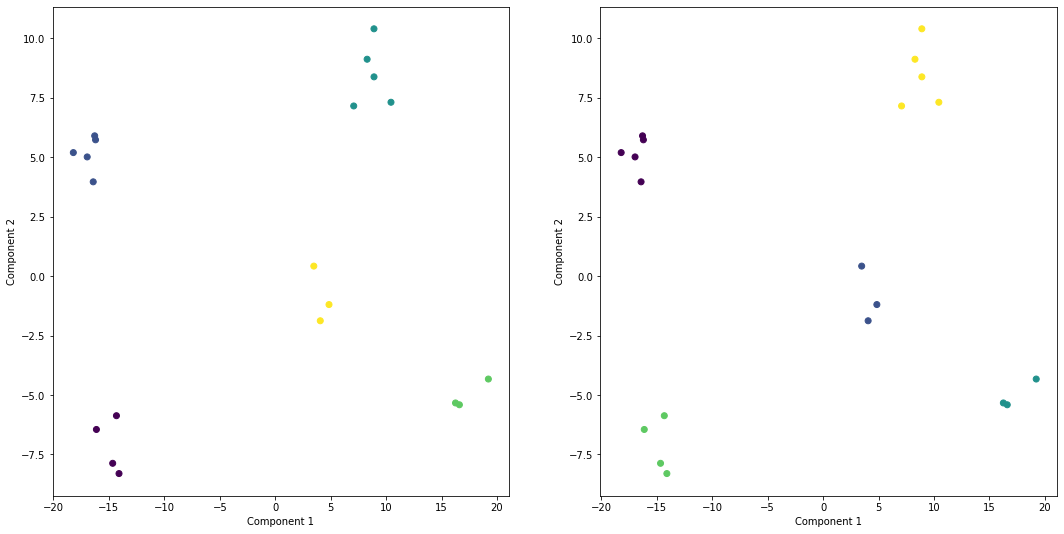

In [32]:
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

fig, ax = plt.subplots(1,2, figsize=(18,9))
ax[0].scatter(pca_test[:,0], pca_test[:,1], c=y_test)
ax[0].set_ylabel("Component 2")
ax[0].set_xlabel("Component 1")
ax[1].scatter(pca_test[:,0], pca_test[:,1], c=test_pred)
ax[1].set_ylabel("Component 2")
ax[1].set_xlabel("Component 1")
plt.show()

## Tuning the k hyperparameter

Generally speaking when kmeans is used, it is in an unsupervised setting where there is no ground truth to determine model performance. There are a number of unsupervised evaluation metrics however, the silhouette score will be explored here. The silhouette_score is comprised of the average intra cluster distance and the minimum inter cluster distance i.e., it is a measure of how compact clusters are compared to how close together clusters are. Let $a(i)$ and $b(i)$ define the mean intra cluster distances and minimum inter cluster distance for observation $i \in C_{I}$
\begin{align}
    a(i) = \frac{1}{|C_{I}|-1}\sum_{j \in C_{I}, i\neq j}d(i,j) \\
    b(i) = \min_{J\neq I}\frac{1}{|C_{J}|}\sum_{j \in C_{I}}d(i,j)
\end{align}
Then the silhouette value for $i$ is:
\begin{align}
    s(i) = \frac{b(i)-a(i)}{max\{a(i),b(i)\}}
\end{align}

Generally speaking, the average silhouette score over all samples is used for evaluation. By examining the equation for $s(i)$ one observes that as clusters become further apart i.e., $b(i) \rightarrow 1$, $s(i) \rightarrow 1$. Clusters being further apart suggests that there is clearer separation, and therefore better clustering quality. The same result is obtained when $a(i) \rightarrow 0$ i.e., clusters become more compact and observations within clusters become 'more similar' with respect to the distance metric used.

### Exercise
Using: 
- The silhouette_score metric provided by sklearn (setting the distance to be euclidean) and; 
- The KMeansClusterer class and ed object from above;
Perform a grid search over the number of clusters from 2 to 10 and create a plot of number of clusters against silhouette score

In [18]:
sil_score = []
clusters = np.arange(2,10)
#Insert Your Code Here


## Extension: Kmeans with manhatten distance

The manhatten distance is a very popular distance metric in machine learning. Let $x,y \in \mathbb{R}^{p}$ then the manhatten distance is defined as:
\begin{align}
    \sum_{i=1}^{p}|x_{i}-y_{i}|
\end{align}

It is commonly used in regression as a regularisation criteria (often referred to as the $L_{1}$ distance).

### Exercise
Implement the manhetten distance by subclassing the DistanceMetric abstract class. Run kmeans clustering using the manhatten distance metric and visualise the results using the two PCA components from above. 

In [72]:
class ManhattenDistance(DistanceMetric):
     def distance_calculation(self, x:np.array, y:np.array)->np.array:
            return (np.sum(np.absolute(x - y)))


Experiment with different numbers of clusters and see whether the manhatten distance can reasonably define all of the clusters in the orginal dataset!

## Extension: Altering dataset generating process

Ref: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html

Try experimenting with the transformation and cluster_std parameters below. They effect the extent to which the anisotropic and unqeual variance datasets, below breach the assumption of kmeans. (After the kernel lecture try thinking about how the transformation parameter might work!)

In [73]:
centres = np.array([[2,2],[0,0]])
n_features = 2
np.random.seed(2)
transformation = np.random.uniform(-1,1,(n_features, n_features))
cluster_std = [2.5, 0.5]

In [30]:
X, y = make_blobs(
    n_samples=500,
    n_features=n_features,
    centers=centres,
    random_state=42
)
X_aniso = np.dot(X, transformation)
X_varied, y_varied = make_blobs(
    n_samples=500, 
    centers=centres,
    cluster_std=cluster_std, 
    random_state=42
)


kmc = KMeansClusterer(n_clusters=2, distance_metric=ed, max_iter=1000)
kmc.fit(X)
res = kmc.predict(X)

fig, ax = plt.subplots(1,2, figsize=(12,9))
ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[1].scatter(X[:, 0], X[:, 1], c=res)
ax[0].set_title("Standard")
plt.show()

kmc = KMeansClusterer(n_clusters=2, distance_metric=ed, max_iter=1000)
kmc.fit(X_aniso)
res_aniso = kmc.predict(X_aniso)

fig, ax = plt.subplots(1,2, figsize=(12,9))
ax[0].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
ax[1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=res_aniso)
ax[0].set_title("Anisotropically Distributed Blobs")
plt.show()

kmc = KMeansClusterer(n_clusters=2, distance_metric=ed, max_iter=1000)
kmc.fit(X_varied)
res_var = kmc.predict(X_varied)

fig, ax = plt.subplots(1,2, figsize=(12,9))
ax[0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
ax[1].scatter(X_varied[:, 0], X_varied[:, 1], c=res_var)
ax[0].set_title("Unequal Variance")
plt.show()

NameError: name 'transformation' is not defined

## Summary

By the end of this notebook you should have implemented the kmeans clustering algorithm from scratch using numpy as well as experimented with unsupervised hyperparameter tuning using the silhouette score, experimented with different distance metrics and finally gained intuition regarding how the assumptions of kmeans clustering effect the algorithm.